In [37]:
import sys
sys.path.insert(0, 'utils.py')


In [38]:
# /!\ Before running the lab make sure every additional libraries is installed 



# Import local libraries
from utils import *
import time
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt


# Reading of one LiDAR scan

In [39]:
n_frame = 0
actor = 'ego_vehicle'

points = get_point_cloud(n_frame, actor)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

flag_display = True

# Voxel Down sampling

To reduce the number of points and accelerate the computation use the function _voxel_down_sample()_ of open3D.

In [40]:
downpcd = pcd.voxel_down_sample(voxel_size=0.0005)
if flag_display:
    o3d.visualization.draw_geometries([downpcd])

# Normals estimation
We would like to detect opstacles, to do that the first step is to estimate normals to obtain the local orientation of the point cloud.

Use the function _estimate_normals()_ of open3D to estimate this normals.

In [41]:
#ToDo estimate the normals, radius is the size of the neighborhood of the sensor, max_nn is the maximum number of nearest neighbors
o3d.geometry.PointCloud.estimate_normals( downpcd, search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=3,  max_nn=30))


if flag_display:
    o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

In [42]:
downpcd.colors = o3d.utility.Vector3dVector(np.abs(np.array(downpcd.normals)))

if flag_display:
    o3d.visualization.draw_geometries([downpcd])

# Ground and objects segmentation

Based on the height of each point, the local orientation of the points cloud arround this point and eventually the variation of this orientation filter the ground to obtain a new points cloud whith only the ground points and another one with only the objects on top of this ground.

For both of these new points clouds you can also filter the points corresponding to the roof of the ego vehicle.

In [43]:
def ground_filtering(pcd):
    # Assuming 'normals' is your array of normal vectors
    z_components = np.asarray(pcd.normals)[:, 2]

    # Plot histogram of z-components for threshold determination
    # plt.hist(z_components, bins=50)
    # plt.xlabel('z-component of Normal Vectors')
    # plt.ylabel('Frequency')
    # plt.title('Distribution of z-components of Normal Vectors')
    # plt.show()

    # Experiment with different thresholds
    threshold = 0.8  # Adjust this value based on the histogram
    pcd_ground = pcd.select_by_index(np.where((z_components < -threshold) | (z_components > threshold))[0])
    pcd_ground = pcd_ground.select_by_index(np.where(np.asarray(pcd_ground.points)[:, 2] <0.1)[0])
    return pcd_ground

pcd_ground = ground_filtering(downpcd)

if flag_display:
    o3d.visualization.draw_geometries([pcd_ground])

In [44]:
def objects_filtering(pcd):
    z_components = np.asarray(pcd.normals)[:, 2]
    height = np.asarray(pcd.points)[:, 2]
    threshold = 0.8  # Adjust this value based on the histogram
    #first level of filtering based on spatial height of points
    pcd_objects = pcd.select_by_index(np.where(height > 0.5)[0])
    #z-components of filtered point cloud
    z_components = np.asarray(pcd_objects.normals)[:, 2]
    pcd_objects = pcd_objects.select_by_index(np.where((z_components > -threshold) & (z_components < threshold))[0])

    return pcd_objects

pcd_objects = objects_filtering(downpcd)

if flag_display:
    o3d.visualization.draw_geometries([pcd_objects])

# Clustering

Now that the points of the objects are not connected to the ground anymore we can regroup all the points of the same object on one cluster.

To do that, use the function _cluster_dbscan()_ of open3D to obtain the cluster id for each point.

In [ ]:
def clustering(pcd_objects):
    
    #eps: maximum distance between two samples for one to be considered as in the neighborhood of the other.
    #min_points: number of samples in a neighborhood for a point to be considered as a core point.

    cluster_ids = np.array(pcd_objects.cluster_dbscan(eps=0.5, min_points=10, print_progress=True))
    
    cluster_nb = cluster_ids.max()
    colors = plt.get_cmap("tab20")(cluster_ids / (cluster_nb if cluster_nb > 0 else 1))
    colors[cluster_ids < 0] = 0
    pcd_objects.colors = o3d.utility.Vector3dVector(colors[:, :3])
    return pcd_objects, cluster_ids

pcd_objects, cluster_ids = clustering(pcd_objects)

print("The points cloud has", cluster_ids.max() + 1, "clusters")

if flag_display:
    o3d.visualization.draw_geometries([pcd_objects])

The points cloud has 61 clusters
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


# Bounding Boxes estimation
Estimate for each of these clusters its bounding box. You can use the function _get_axis_aligned_bounding_box()_ or _get_oriented_bounding_box()_ of open3D.

What are the limits of these functions ?

You can keep only the small bounding boxes correponding to the small objects (such as vehicles or pedestrians and not buildings)

In [48]:
def cluster_boxes(pcd_objects, cluster_ids):
    
    # Bounding boxes
    boxes = []
    for cluster_id in np.unique(cluster_ids):
        if cluster_id == -1:
            continue
        cluster_points = pcd_objects.select_by_index(np.where(cluster_ids == cluster_id)[0])
        box = cluster_points.get_axis_aligned_bounding_box()
        if box.volume() < 5:  # Adjust the volume threshold based on your requirements
            boxes.append(box)
    return boxes

boxes = cluster_boxes(pcd_objects, cluster_ids)

obj_to_display = boxes
obj_to_display.append(pcd_objects)

if flag_display:
    o3d.visualization.draw_geometries(obj_to_display)

# Objects detection and tracking on LiDAR scans

Applied the previous functions on the different scan to estimate the bounding boxes.

### Bounding boxes association

Create a function to associate the bounding boxes of the current time to the one of the previous time based the shortest distances of there centers.

### Bounding boxes orientation estimation
Based on these association estimate the orientation of there motion to correct the orientation of the bounding boxes.

### Points cloud mapping
Build a map by accumulating the different points cloud and removing the moving objects (keep the cluster id and add a new one for the ground points)

### Iterative Closest Point tracking
To better associate the clusters you can also use the function _icp()_ of open3D on each cluster

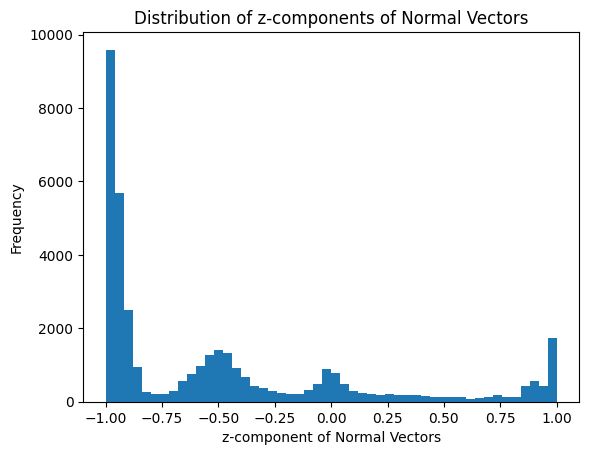

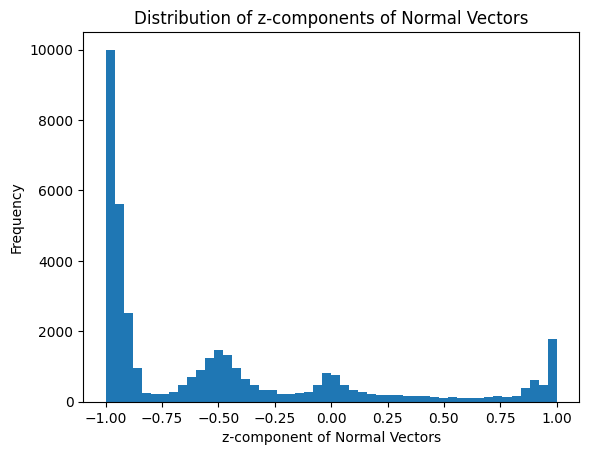

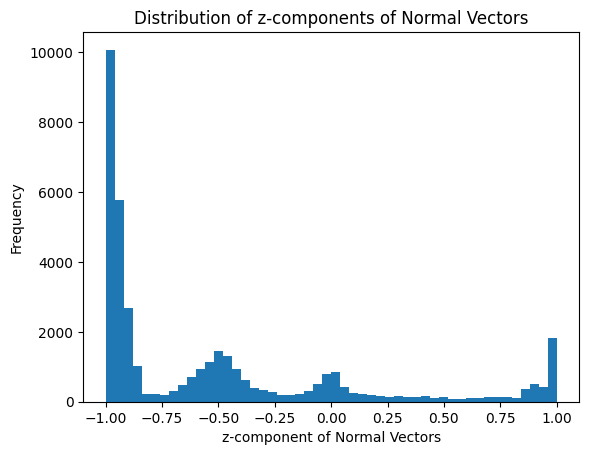

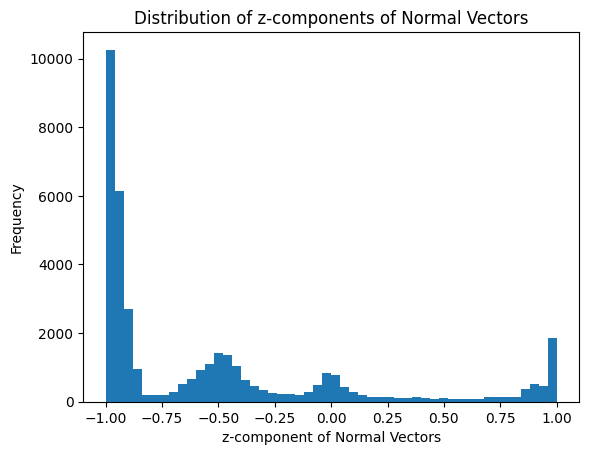

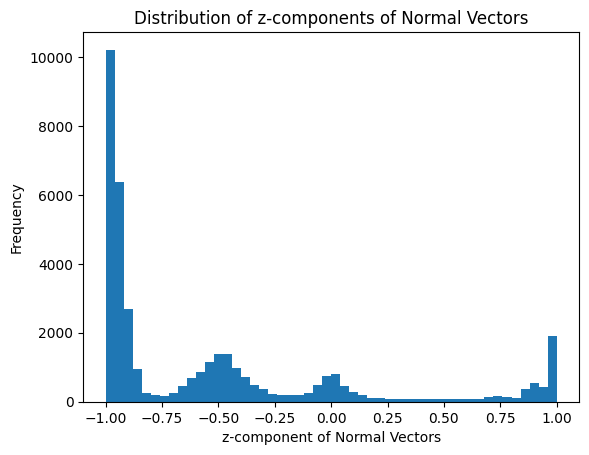

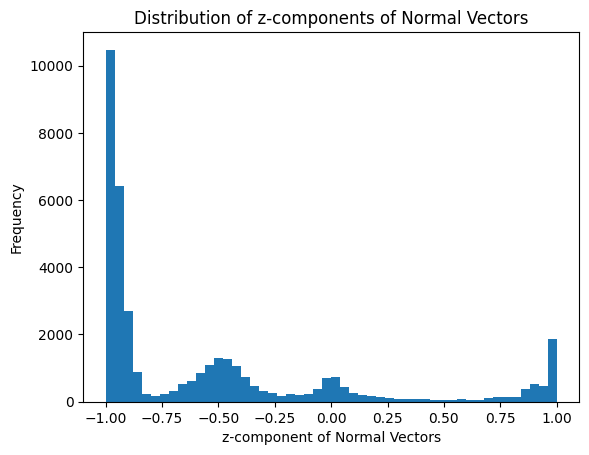

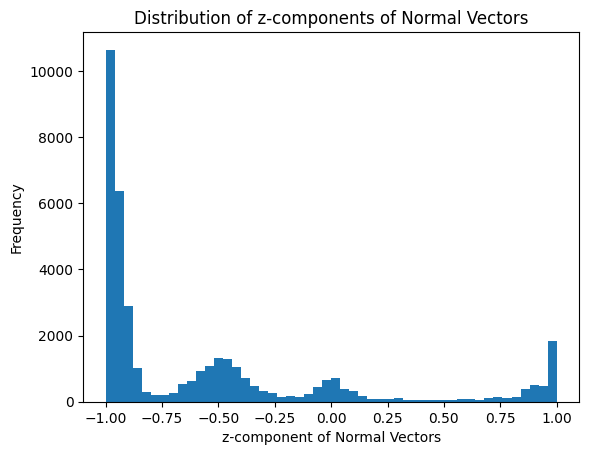

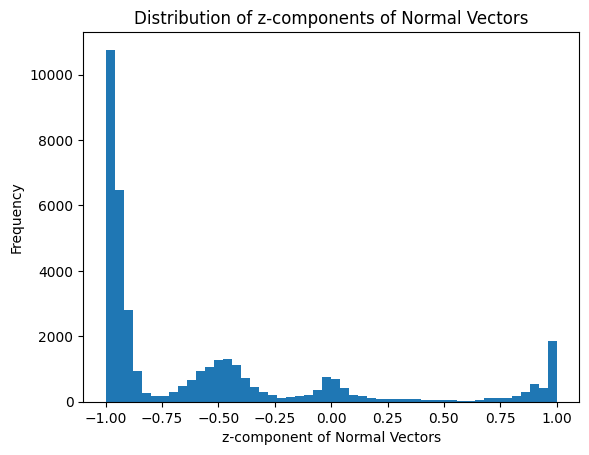

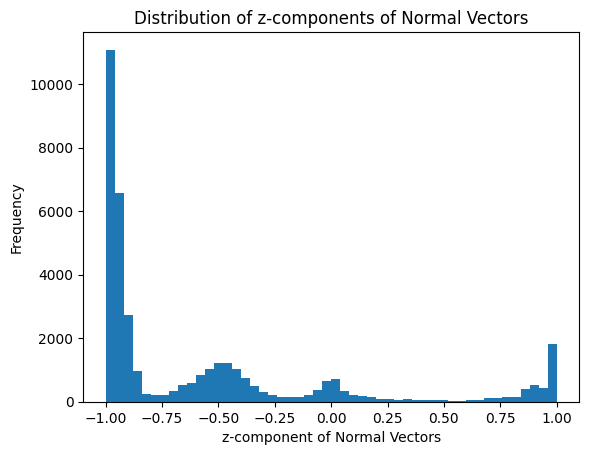

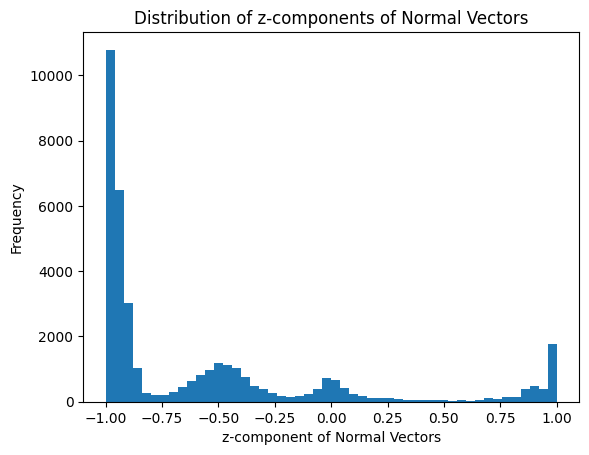

KeyboardInterrupt: 

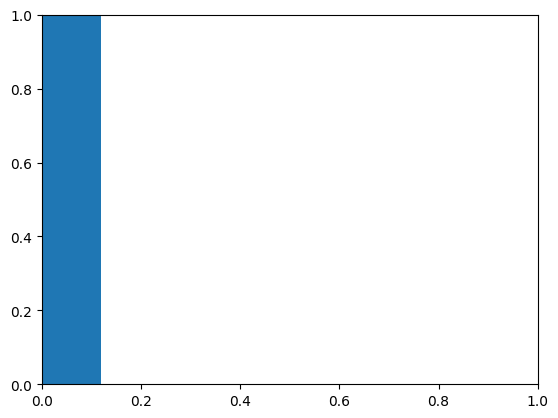

In [ ]:
# Initialize Open3D Visualizer
if flag_display:
    vis = o3d.visualization.Visualizer()
    vis.create_window()

for n_frame in range(nb_frames):
    
    # Read point cloud
    points = get_point_cloud(n_frame, actor)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # Voxel down sampling
    downpcd = pcd.voxel_down_sample(voxel_size=0.005)
    
    # Transform points cloud from the LiDAR to the world frame
    tf = get_tf_lidar2world(actor, n_frame)
    downpcd.transform(tf)
    
    # Estimate normals
    downpcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=3,
                                                          max_nn=15))
    downpcd.colors = o3d.utility.Vector3dVector(np.abs(np.array(downpcd.normals)))
    
    # Filter ground points
    pcd_ground = ground_filtering(downpcd)
    
    
    # Filter objects points
    pcd_objects = objects_filtering(downpcd)
    
    # Clustering
    pcd_objects, cluster_ids = clustering(pcd_objects)
    
    if flag_display:
        # Clear previous geometries and add new point cloud to visualizer
        vis.clear_geometries()
        vis.add_geometry(pcd_objects)
        
        # Update the visualizer to show the new point cloud
        vis.poll_events()
        vis.update_renderer()

        # Wait before updating the points cloud (adjust time as needed)
        time.sleep(0.1)

if flag_display:
    # Close the visualizer
    vis.destroy_window()